<a href="https://colab.research.google.com/github/serenayan/persona-alpha/blob/master/Gaussian_Splatting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Guided Gaussian Splatting
Gaussian Splatting by https://repo-sam.inria.fr/fungraph/3d-gaussian-splatting/

CLIP Guidance by CLIP and @aman_gif

Colab packages: https://github.com/camenduru/gaussian-splatting-colab

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
%cd /content
!git clone --recursive https://github.com/camenduru/gaussian-splatting
!pip install -q plyfile

%cd /content/gaussian-splatting
!pip install -q https://huggingface.co/camenduru/gaussian-splatting/resolve/main/diff_gaussian_rasterization-0.0.0-cp310-cp310-linux_x86_64.whl
!pip install -q https://huggingface.co/camenduru/gaussian-splatting/resolve/main/simple_knn-0.0.0-cp310-cp310-linux_x86_64.whl

/content
Cloning into 'gaussian-splatting'...
remote: Enumerating objects: 603, done.
remote: Counting objects: 100% (247/247), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 603 (delta 213), reused 199 (delta 199), pack-reused 356
Receiving objects: 100% (603/603), 2.09 MiB | 26.41 MiB/s, done.
Resolving deltas: 100% (347/347), done.
Submodule 'SIBR_viewers' (https://gitlab.inria.fr/sibr/sibr_core) registered for path 'SIBR_viewers'
Submodule 'submodules/diff-gaussian-rasterization' (https://github.com/graphdeco-inria/diff-gaussian-rasterization) registered for path 'submodules/diff-gaussian-rasterization'
Submodule 'submodules/simple-knn' (https://gitlab.inria.fr/bkerbl/simple-knn.git) registered for path 'submodules/simple-knn'
Cloning into '/content/gaussian-splatting/SIBR_viewers'...
remote: Enumerating objects: 2866, done.        
remote: Counting objects: 100% (1399/1399), done.        
remote: Compressing objects: 100% (699/699), done.        
remote: Tota

In [ ]:
!pip install git+https://github.com/facebookresearch/ImageBind

  Cloning https://github.com/facebookresearch/ImageBind to /tmp/pip-req-build-w273c4u_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/ImageBind /tmp/pip-req-build-w273c4u_
  Resolved https://github.com/facebookresearch/ImageBind to commit 95d27c7fd5a8362f3527e176c3a80ae5a4d880c0
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/pytorchvideo.git (to revision 28fe037d212663c6a24f373b94cc5d478c8c1a1d) to /tmp/pip-install-dt50dtkw/pytorchvideo_e23e4f70111f48e58fe480fec662e0b1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-install-dt50dtkw/pytorchvideo_e23e4f70111f48e58fe480fec662e0b1
  Running command git rev-parse -q --verify 'sha^28fe037d212663c6a24f373b94cc5d478c8c1a1d'
  Running command git fetch -q https://github.com/facebookresearch/pytorchvideo.git 28fe037d212663c6a24f373b94cc5d478c8c1a1d
  Running command git checkout -q 28fe037d2126

In [ ]:
!pip install open_clip_torch celluloid matplotlib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.9 MB/s eta 0:00:00


In [ ]:
import os
import torch
from random import randint
from utils.loss_utils import l1_loss, ssim
from gaussian_renderer import render, network_gui
import sys
from scene import Scene, GaussianModel
from scene.cameras import Camera
from scene.gaussian_model import BasicPointCloud
from utils.sh_utils import SH2RGB
from utils.general_utils import safe_state
import uuid
from tqdm import tqdm
from utils.image_utils import psnr
from argparse import ArgumentParser, Namespace
from arguments import ModelParams, PipelineParams, OptimizationParams
from matplotlib import pyplot as plt

In [ ]:
import torch
from PIL import Image
import open_clip
oclip = 'ViT-B-32'
model, _, preprocess = open_clip.create_model_and_transforms(oclip, pretrained='laion2b_s34b_b79k')

model.requires_grad_(False).cuda().half()
tokenizer = open_clip.get_tokenizer(oclip)

open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [ ]:
from torchvision.transforms import Normalize

clippp = Normalize(mean=model.visual.image_mean, std=model.visual.image_std)
clippp

Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))

In [ ]:
model = torch.jit.script(model)

In [ ]:
import numpy as np

num_pts = 100
print(f"Generating random point cloud ({num_pts})...")

# We create random points inside the bounds of the synthetic Blender scenes
camera_extent = 5.0
xyz = np.random.normal(size=(num_pts, 3))
xyz = 1.3 * xyz / np.linalg.norm(xyz, axis=-1, keepdims=True)
shs = np.random.random((num_pts, 3)) / 255.0
pcd = BasicPointCloud(points=xyz, colors=SH2RGB(shs), normals=np.zeros((num_pts, 3)))

Generating random point cloud (100)...


In [ ]:
def random_crops(img, n, resize_to=224, min_size=0.5, max_size=1.0):
    sizes = torch.rand(n) * (max_size - min_size) + min_size
    top_left = torch.rand(n, 2) * (1.0 - sizes[:, None])
    transforms = torch.eye(2).unsqueeze(0).repeat(n, 1, 1) * sizes[:, None, None]
    transforms = torch.cat([transforms, top_left[:, :, None]], dim=-1)
    grids = torch.nn.functional.affine_grid(transforms, [n, img.shape[1], resize_to, resize_to], align_corners=True).to(img.device)
    return torch.nn.functional.grid_sample(img.repeat(n, 1, 1, 1), grids, align_corners=True)


In [ ]:
from celluloid import Camera as PltCamera
from math import floor
try:
    from torch.utils.tensorboard import SummaryWriter
    TENSORBOARD_FOUND = True
except ImportError:
    TENSORBOARD_FOUND = False

def rot2d(angle):
    return torch.tensor([
        [torch.cos(angle), torch.sin(angle), torch.tensor(0)],
       [-torch.sin(angle), torch.cos(angle), torch.tensor(0)],
        [torch.tensor(0), torch.tensor(0), torch.tensor(1)]
    ])

def normalize(x):
    return x / x.norm(dim=-1, keepdim=True)
def look_at(eye, at, up):
    z = normalize(eye - at)
    x = normalize(torch.linalg.cross(up, z))
    y = normalize(torch.linalg.cross(z, x))
    rot = torch.stack([x, y, z]).T
    trans = torch.tensor([x @ eye, y @ eye, z @ eye])
    return rot, trans


def show(tensor):
    tensor = tensor.detach().permute(1, 2, 0)
    plt.imshow(tensor.cpu().numpy())

def training(prompt, dataset, opt, pipe, testing_iterations, saving_iterations, checkpoint_iterations, checkpoint, debug_from):
    first_iter = 0
    gaussians = GaussianModel(dataset.sh_degree)
    # scene = Scene(dataset, gaussians)
    gaussians.create_from_pcd(pcd, camera_extent)
    gaussians.training_setup(opt)
    if checkpoint:
        (model_params, first_iter) = torch.load(checkpoint)
        gaussians.restore(model_params, opt)

    bg_color = [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    iter_start = torch.cuda.Event(enable_timing = True)
    iter_end = torch.cuda.Event(enable_timing = True)

    viewpoint_stack = None
    ema_loss_for_log = 0.0
    progress_bar = tqdm(range(first_iter, opt.iterations), desc="Training progress")
    first_iter += 1
    # dbgfig = plt.figure()
    fig = plt.figure()
    camera = PltCamera(fig)

    for iteration in range(first_iter, opt.iterations + 1):

        iter_start.record()

        gaussians.update_learning_rate(iteration)

        # Every 1000 its we increase the levels of SH up to a maximum degree
        if iteration % 1000 == 0:
            gaussians.oneupSHdegree()

        # Pick a random Camera
        # if not viewpoint_stack:
        #    viewpoint_stack = scene.getTrainCameras().copy()
        # viewpoint_cam = viewpoint_stack.pop(randint(0, len(viewpoint_stack)-1))
        rand_angle = torch.rand(1) * 3.14159 * 2.0
        rand_pos = camera_extent * torch.tensor([rand_angle.cos(), 0.0, rand_angle.sin()])
        rand_pos[1] = 0.2 + (torch.rand(1) * 2 - 1) * 0.3
        dist, direc = torch.linalg.norm(rand_pos), normalize(rand_pos)
        rand_pos = direc * camera_extent


        # if (iteration % 10) == 0:
        #     rand_pos = torch.tensor([0.0, 0.0, camera_extent])
        #     rand_pos = rand_pos + torch.tensor([torch.tensor(3.14159 * 4.0 * iteration / opt.iterations).cos(), torch.tensor(3.14159 * 4.0 * iteration / opt.iterations).sin(), 0.0])

        rot, trans = look_at(rand_pos, torch.tensor([0.0, 0.0, 0.0]), torch.tensor([0.0, 1.0, 0.0]))

        train_res = floor(512 * (iteration / opt.iterations))
        train_res = 32 * (1 + train_res // 32)
        viewpoint_cam = Camera(
            colmap_id=0,
            R=rot.numpy(), #rand_angle.numpy(),
            T=trans.numpy(), #torch.zeros((3,)).numpy(),
            FoVx=90.0,
            FoVy=90.0,
            image=torch.zeros((3, train_res, train_res)),
            gt_alpha_mask=torch.ones((train_res, train_res)),
            image_name="test",
            uid=0,
        )
        # Render
        if (iteration - 1) == debug_from:
            pipe.debug = True
        render_pkg = render(viewpoint_cam, gaussians, pipe, bg_color=torch.rand(3).cuda())
        image, viewspace_point_tensor, visibility_filter, radii = render_pkg["render"], render_pkg["viewspace_points"], render_pkg["visibility_filter"], render_pkg["radii"]

        # Loss

        views = ["front view", "left side view", "back view", "right side view"]
        qangle = floor(4 * rand_angle / (2 * 3.14159))
        view = views[qangle]

        prompt = prompt.format(view)
        #text = tokenizer(["a photo of a beautiful twink statue, not noisy, not rainbow, cute, accurate anatomy, black background, greeco-roman statue"]).cuda()
        #text = tokenizer([f"a photo of a beautiful twink statue, {view}, not noisy, not rainbow, cute, accurate anatomy, black background, greeco-roman statue"]).cuda()
        #text = tokenizer(["a 3d model of a cyber-sigilist statue, sumerian god, celestialpunk, beautiful, monochrome shiny, gloss"]).cuda()
        text = tokenizer([prompt]).cuda()
        #text = tokenizer([f"a 3d model of an astronaut riding a horse, 3d asset, high quality, not noisy, beautiful, black background"]).cuda()
        #text = tokenizer(["a 3d model of the Mona Lisa, 3d asset, high quality, not noisy, beautiful, black background"]).cuda()
        #text = tokenizer([f"a 3d model of a tabby cat, {view}, 3d asset, high quality, not noisy, beautiful, black background"]).cuda()
        text_vec = model.encode_text(text).float()
        text_vec = text_vec / text_vec.norm(dim=-1, keepdim=True)

        crops = random_crops(image.unsqueeze(0), 32, min_size=0.7, max_size=0.9)
        img_vec = model.encode_image(clippp(crops).half()).float()
        img_vec = img_vec / img_vec.norm(dim=-1, keepdim=True)

        sim = img_vec @ text_vec.T
        clip_loss = -sim.mean()
        # self_sim = -(img_vec @ img_vec.T).mean()
        # loss = (1.0 - opt.lambda_dssim) * Ll1 + opt.lambda_dssim * (1.0 - ssim(image, gt_image))
        loss = clip_loss
        loss.backward()

        iter_end.record()

        if ((iteration % 10) == 0 or iteration == opt.iterations) and iteration > 700:
            rand_pos = torch.tensor([0.0, 0.0, camera_extent])
            angle = 3.14159 * 2.0 * iteration / opt.iterations
            rand_pos = camera_extent * torch.tensor([torch.tensor(angle).cos(), 0.0, torch.tensor(angle).sin()])

            rot, trans = look_at(rand_pos, torch.tensor([0.0, 0.0, 0.0]), torch.tensor([0.0, 1.0, 0.0]))

            dbg_cam = Camera(
                colmap_id=0,
                R=rot.numpy(), #rand_angle.numpy(),
                T=trans.numpy(), #torch.zeros((3,)).numpy(),
                FoVx=90.0,
                FoVy=90.0,
                image=torch.zeros((3, 512, 512)),
                gt_alpha_mask=torch.ones((512, 512)),
                image_name="test",
                uid=0,
            )
            image = render(dbg_cam, gaussians, pipe, background)["render"]

            show(image)
            camera.snap()

        if iteration == opt.iterations:
            return camera.animate(blit = False, interval = 50), gaussians


        with torch.no_grad():
            # Progress bar
            ema_loss_for_log = 0.4 * loss.item() + 0.6 * ema_loss_for_log
            if iteration % 10 == 0:
                progress_bar.set_postfix({"Loss": f"{ema_loss_for_log:.{7}f}"})
                progress_bar.update(10)
            if iteration == opt.iterations:
                progress_bar.close()

            # Log and save
            # training_report(tb_writer, iteration, Ll1, loss, l1_loss, iter_start.elapsed_time(iter_end), testing_iterations, scene, render, (pipe, background))
            if (iteration in saving_iterations):
                print("\n[ITER {}] Saving Gaussians".format(iteration))
                scene.save(iteration)

            # Densification
            if iteration < opt.densify_until_iter:
                # Keep track of max radii in image-space for pruning
                gaussians.max_radii2D[visibility_filter] = torch.max(gaussians.max_radii2D[visibility_filter], radii[visibility_filter])

                gaussians.add_densification_stats(viewspace_point_tensor, visibility_filter)

                densify = iteration % opt.densification_interval == 0
                if iteration > opt.densify_from_iter and densify:
                    size_threshold = 20 if iteration > opt.opacity_reset_interval else None
                    gaussians.densify_and_prune(opt.densify_grad_threshold, 0.005, camera_extent, size_threshold)

                if iteration % opt.opacity_reset_interval == 0 or (dataset.white_background and iteration == opt.densify_from_iter):
                    gaussians.reset_opacity()

            # Optimizer step
            if iteration < opt.iterations and (iteration % 1) == 0:
                gaussians.optimizer.step()
                gaussians.optimizer.zero_grad(set_to_none = True)

            if (iteration in checkpoint_iterations):
                print("\n[ITER {}] Saving Checkpoint".format(iteration))
                torch.save((gaussians.capture(), iteration), scene.model_path + "/chkpnt" + str(iteration) + ".pth")

In [ ]:
from tqdm import tqdm
try:
    tqdm._instances.clear()
except:
    pass

# Run it!
Note: first time it will take a while to start to JIT the CLIP model

Number of points at initialisation :  100


Training progress:   0%|          | 0/2500 [00:00<?, ?it/s]<ipython-input-10-dc1d930807c4>:115: UserWarning: operator() profile_node %307 : int[] = prim::profile_ivalue(%305)
 does not have profile information (Triggered internally at ../third_party/nvfuser/csrc/graph_fuser.cpp:104.)
  text_vec = model.encode_text(text).float()
Training progress: 100%|█████████▉| 2490/2500 [05:35<00:01,  7.42it/s, Loss=-0.5717011]


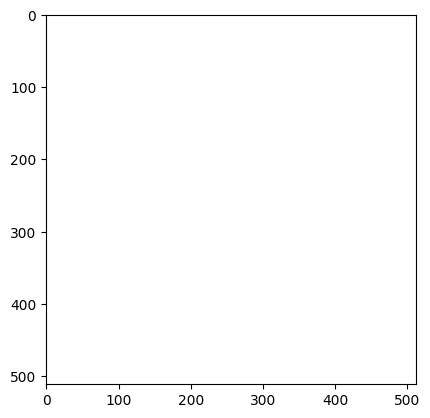

In [ ]:
from IPython.core.display import HTML

prompt = "a 3d model of Van Gogh's Sunflowers, 3d asset, high quality, not noisy, beautiful, black background"
# Put a {} in your prompt to have view depedent prompting
# i.e "a cat, {}" -> "a cat, front view", "a cat, side view" etc

parser = ArgumentParser()
model_params = ModelParams(parser)
opt_params = OptimizationParams(parser)
pp = PipelineParams(parser)
args, _ = parser.parse_known_args()
args.iterations = 2500
args.position_lr_init = 1e-2
args.position_lr_final = 1e-5
args.position_lr_max_steps = args.iterations
# args.opacity_reset_interval = 1000
torch.manual_seed(2023)
animation, gaussians = training(prompt, model_params.extract(args), opt_params.extract(args), pp.extract(args), [], [], [], None, -1)
HTML(animation.to_html5_video())

In [ ]:
gaussians.save_ply("../output.ply")

/content/gaussian-splatting
